# Comparing European Soccer:
## Germany's Bundesliga vs. England's Premier League
### Our goal is to see if statstical data can show that one league is "better" than the other.

Data was collected from 2 sources:
1. A kaggle SQLite dataset: https://www.kaggle.com/hugomathien/soccer/downloads/soccer.zip
2. CSV files with soccer data geared toward betting from this site: http://www.football-data.co.uk/

### First, packages were initalized and data placed in pandas dataframes.

In [19]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from bokeh.charts import BoxPlot, show
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import Range1d
from bokeh.palettes import brewer

### From the SQLite database, player data is queried for both leagues from the 2011/12 - 2015/16 seasons.
### We imported Overall Player Rating, Player Potential Rating, and Player Free Kick Accuracy.

The Overall Rating is something calculated by FIFA. They don't share the formula, but in general the best players have scores in the low 90s and the average player on the average team will probably be in the 70s.

The data is spread out over the database so many joins were necessary to link players to leagues, teams, and match data.

In [20]:
database = '/Users/ccajas/Downloads/database.sqlite'
con = sqlite3.connect(database)

#Grab data on EPL and BL1 players from 2011/12 - 2015/16 seasons

data = '''SELECT p.player_name, t.team_long_name, l.name,
            pa.overall_rating, pa.potential, pa.free_kick_accuracy, m.season
            FROM Player_Attributes pa
            JOIN Player p
            ON pa.player_api_id = p.player_api_id
            JOIN Match m
            ON (p.player_api_id = m.away_player_1 OR p.player_api_id = m.away_player_2
            OR p.player_api_id = m.away_player_3 OR p.player_api_id = m.away_player_4 
            OR p.player_api_id = m.away_player_5 OR p.player_api_id = m.away_player_6 
            OR p.player_api_id = m.away_player_7 OR p.player_api_id = m.away_player_8 
            OR p.player_api_id = m.away_player_9 OR p.player_api_id = m.away_player_10 
            OR p.player_api_id =  m.away_player_11)
            JOIN League l
            ON m.league_id = l.id
            JOIN Team t
            ON m.away_team_api_id = t.team_api_id
            WHERE (m.season = '2015/2016' OR m.season = '2014/2015' OR m.season = '2013/2014' 
            OR m.season = '2012/2013' OR m.season = '2011/2012')
            AND (l.name = 'Germany 1. Bundesliga' OR l.name = 'England Premier League')
            '''

df = pd.read_sql_query(data, con=con).drop_duplicates()
df.head()

,player_name,team_long_name,name,overall_rating,potential,free_kick_accuracy,season
0,Richard Stearman,Wolverhampton Wanderers,England Premier League,64.0,73.0,32.0,2011/2012
1,Richard Stearman,Wolverhampton Wanderers,England Premier League,65.0,69.0,32.0,2011/2012
3,Richard Stearman,Wolverhampton Wanderers,England Premier League,65.0,73.0,32.0,2011/2012
4,Richard Stearman,Wolverhampton Wanderers,England Premier League,66.0,73.0,32.0,2011/2012
8,Richard Stearman,Wolverhampton Wanderers,England Premier League,68.0,73.0,32.0,2011/2012


### Next, the dataframe is cleaned up. 
1. Columns are given proper names
2. Individual player scores are grouped by league, season, and team
3. Mean Player Overall Rating scores are calculated by teams.
4. Since the Season column is a string, it is split and converted to an integer

In [21]:
cols = ['Player', 'Team', 'League', 'Overall_Rating', 'Potential', 'Free_Kick_Accuracy', 'Season']
df_teams = df.copy()
df_teams.columns = cols
df_teams = df_teams.groupby(['League', 'Season','Team']).mean().reset_index(drop=False)
df_teams['Year'] = df_teams.Season.str[:4].apply(int)
df_teams.head(10)

,League,Season,Team,Overall_Rating,Potential,Free_Kick_Accuracy,Year
0,England Premier League,2011/2012,Arsenal,77.046296,81.858025,55.629630,2011
1,England Premier League,2011/2012,Aston Villa,73.423529,77.761765,46.791176,2011
2,England Premier League,2011/2012,Blackburn Rovers,70.820069,75.529412,46.487889,2011
3,England Premier League,2011/2012,Bolton Wanderers,70.666667,75.093851,47.825243,2011
4,England Premier League,2011/2012,Chelsea,79.146497,82.117834,57.054140,2011
5,England Premier League,2011/2012,Everton,75.650000,79.288889,55.788889,2011
6,England Premier League,2011/2012,Fulham,73.605016,77.297806,53.009404,2011
7,England Premier League,2011/2012,Liverpool,76.657895,80.809211,56.266447,2011
8,England Premier League,2011/2012,Manchester City,80.701695,84.084746,62.132203,2011
9,England Premier League,2011/2012,Manchester United,78.835329,82.628743,53.859281,2011


### A column is calculated to see how well each team is "living up to their potential". This is done by calculating the percent difference between player's Overall Rating score and Potential scores. The larger the number, the more the players are not living up to their potential.

In [22]:
per_dif = (((df_teams['Potential'] - df_teams['Overall_Rating'])/df_teams['Potential'])*100).round(2)

df_teams['Rating_vs_Potential'] = per_dif
df_teams.head()

,League,Season,Team,Overall_Rating,Potential,Free_Kick_Accuracy,Year,Rating_vs_Potential
0,England Premier League,2011/2012,Arsenal,77.046296,81.858025,55.629630,2011,5.88
1,England Premier League,2011/2012,Aston Villa,73.423529,77.761765,46.791176,2011,5.58
2,England Premier League,2011/2012,Blackburn Rovers,70.820069,75.529412,46.487889,2011,6.24
3,England Premier League,2011/2012,Bolton Wanderers,70.666667,75.093851,47.825243,2011,5.90
4,England Premier League,2011/2012,Chelsea,79.146497,82.117834,57.054140,2011,3.62


### Since there are always "bad" teams in a league, we wanted to see if there's a difference in player quality for the top teams of each league each year.
1. The dataframe was broken into 2 based on which league the data is from.
2. Each league's dataframe was grouped, sorted, and the top 3 teams with the highest average player Overall Rating  were chosen.
3. The dataframes with top teams per league were concated together.

In [23]:
#Identify the leagues
epl_only = (df_teams.League == 'England Premier League')
bl_only = (df_teams.League == 'Germany 1. Bundesliga')

#Sort, groupby, pick top 3
epl = df_teams[epl_only].groupby(['Year','League','Team','Potential','Free_Kick_Accuracy','Rating_vs_Potential']).mean().Overall_Rating.groupby(level=0, group_keys=False).nlargest(3).reset_index(drop=False)
bl = df_teams[bl_only].groupby(['Year','League','Team','Potential','Free_Kick_Accuracy', 'Rating_vs_Potential']).mean().Overall_Rating.groupby(level=0, group_keys=False).nlargest(3).reset_index(drop=False)

#put them back together
top_teams = [epl, bl]
top3 = pd.concat(top_teams)

top3.head(30)

,Year,League,Team,Potential,Free_Kick_Accuracy,Rating_vs_Potential,Overall_Rating
0,2011,England Premier League,Manchester City,84.084746,62.132203,4.02,80.701695
1,2011,England Premier League,Chelsea,82.117834,57.054140,3.62,79.146497
2,2011,England Premier League,Manchester United,82.628743,53.859281,4.59,78.835329
3,2012,England Premier League,Manchester City,84.100000,62.027273,4.45,80.357576
4,2012,England Premier League,Manchester United,82.520710,55.100592,4.32,78.952663
5,2012,England Premier League,Chelsea,82.347670,56.577061,5.51,77.813620
6,2013,England Premier League,Manchester City,83.817881,55.317881,4.44,80.096026
7,2013,England Premier League,Chelsea,83.534653,57.574257,4.95,79.396040
8,2013,England Premier League,Manchester United,82.775956,54.852459,4.95,78.677596
9,2014,England Premier League,Manchester City,83.431438,54.742475,4.60,79.595318


### Finally we made charts to see if they can tell us which league is "better"

#### Our first graphic shows that on average, England has better players. Data from all teams, not just the top 3, were used

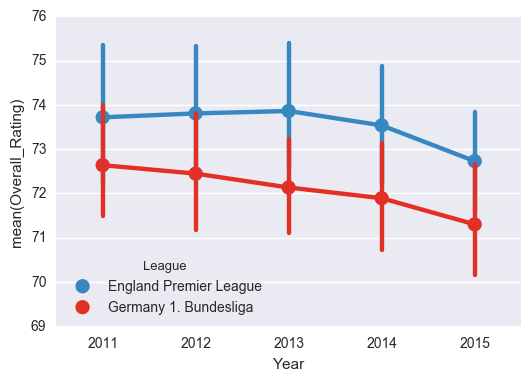

In [24]:
sns.set_style("darkgrid")
sns.pointplot(x="Year", y="Overall_Rating", hue='League', palette='Blues_d',data=df_teams[epl_only])
sns.pointplot(x="Year", y="Overall_Rating", hue='League', palette='Reds_d',data=df_teams[bl_only])

### Here's another look at the same data from above, but shown with boxplots to illustrate the range of scores better. This was done with Bokeh.

In [25]:
palette = brewer['Dark2'][4]

output_notebook()

bottom, top = 65, 85
b = BoxPlot(df_teams, 
            values='Overall_Rating', 
            label=['Year','League'],
            color='League', 
            legend=None, 
            title='Annual Player Overall Ratings',
            width=1000,
           palette=palette)
b.y_range = Range1d(bottom, top)
show(b,notebook_handle=True)

Loading BokehJS ...

### Next, we compared the best teams in each league. Bayern Munich seems to pull up the Bundesliga average. Premier League teams have a more consistent higher scores.

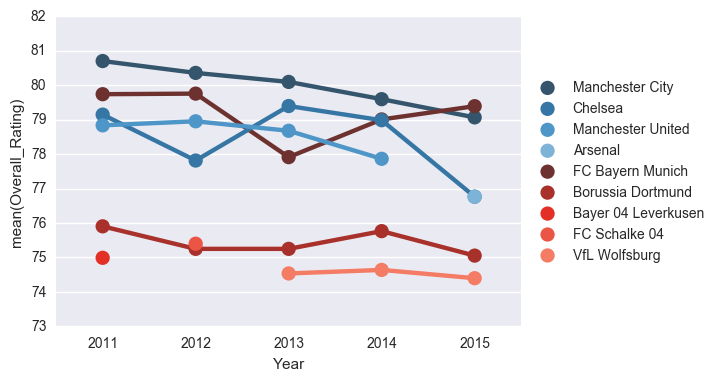

In [26]:
#averages of top 3 teams of each league.
sns.set_style("darkgrid")
sns.pointplot(x="Year", y="Overall_Rating", hue='Team', palette='Blues_d',data=epl)
sns.pointplot(x="Year", y="Overall_Rating", hue='Team', palette='Reds_d',data=bl)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))

### Last, we wanted to see which league has the larger gap between Player Overall Rating and Player Potential. It looks like there is a larger gap in Bundesliga.

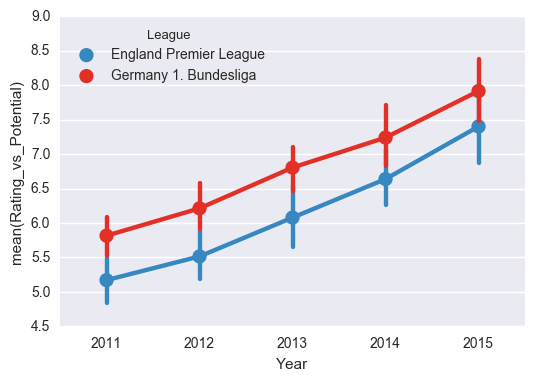

In [27]:
#Players not living up to their potential. The lower the number, the more they're not performing
sns.pointplot(x="Year", y="Rating_vs_Potential",hue='League', palette='Blues_d',agg='max', data=df_teams[epl_only])
sns.pointplot(x="Year", y="Rating_vs_Potential",hue='League', palette='Reds_d', agg='max,', data=df_teams[bl_only])

## Conculsion thus far: The English Premier League has better players and seems to be the better league.